## Gravity data
We leverage the gravity dataset provided by CEPII: http://www.cepii.fr/cepii/en/bdd_modele/presentation.asp?id=8

Cite: 
- Head, K., Mayer, T. & Ries, J. (2010), The erosion of colonial trade linkages after independence. Journal of International Economics, 81(1):1-14
- Head, K. and T. Mayer, (2014), "Gravity Equations: Toolkit, Cookbook, Workhorse." Handbook of International Economics, Vol. 4,eds. Gopinath, Helpman, and Rogoff, Elsevier. 

In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed/'
    input_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/raw/'

In [40]:
import pandas as pd
import os
from utils import data_loader
import seaborn as sns
import matplotlib.pyplot as plt

In [125]:
reduced_terms_list, df_model = data_loader(output_filepath)

In [3]:
df_gravity = pd.read_csv(os.path.join(input_filepath, 'Gravity_csv_V202102', 'Gravity_V202102.csv'))
df_countries = pd.read_csv(os.path.join(input_filepath, 'Gravity_csv_V202102', 'Countries_V202102.csv'))

/home/ubuntu/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
trade_facilitation_unilateral_variables = [
    'gatt', # Dummy equal to 1 if country is a GATT member in a given year, unilateral.
    'wto', # Dummy equal to 1 if country is a WTO member in a given year, unilateral.
    'eu', #Dummy equal to 1 if country is a EU member in a given year, unilateral.
    #'entry_cost', # Cost of business start-up procedures (% of GNI per capita), unilateral.
    #'entry_proc', # Number of start-up procedures to register a business, unilateral.
    #'entry_time', # Days required to start a business, unilateral.
    #'entry_tp', # Days required to start a business + number of procedures to start a business, unilateral
]

In [85]:
trade_facilitation_bilateral_variables = [
    'rta', # Dummy equal to 1 if origin and destination country are engaged in a regional trade agreement of any type within the given year (Source: WTO), bilateral.
    'rta_coverage', # Coverage of the trade agreement. 0 = “no trade agreement” (r ta = 0). 1 = “goods only”, 2 = “services only”, 3 = “goods and services”. Source: WTO, bilateral.
    'rta_type', # Categorical variable describing type of regional trade agreement if origin and destination country are engaged in a regional trade agreement within the given year and rta = 1 (Source: WTO, see Table ?? for a description of the values taken by this variable), bilateral.    
]

geographic_bilateral_variables = [
    'contig', # Dummy equal to 1 if countries are contiguous, bilateral.
    'dist', # Distance between most populated city of each country, measured in km, bilateral.
    'distw', # Population-weighted distance between most populated cities, measured in km, bilateral
    'distcap', # Distance between capitals, measured in km, bilateral
    'distwces', #  Population-weighted distance between most populated cities, measured in km, calculated using CES formulation with θ = −1 (see Head and Mayer 2010 for more details), bilateral.
]

cultural_bilateral_variables = [
    'comlang_off', # Dummy equal to 1 if countries share common official or primary language, bilateral.
    'comlang_ethno', # Dummy equal to 1 if countries share a common language spoken by at least 9% of the population, bilateral.
    'comcol', # Dummy equal to 1 if countries share a common colonizer post 1945, bilateral.
    'col45', # Dummy equal to 1 if countries are or were in colonial relationship post 1945, bilateral.
    'comleg_pretrans', # Dummy equal to 1 if countries share common legal origins before transition, bilateral.
    'comleg_posttrans', # Dummy equal to 1 if countries share common legal origins after transition, bilateral.
    'transition_legalchange', # Dummy equal to 1 if common legal origin has changed since the above-mentioned transition, bilateral.
    'comrelig', # Religious proximity index (Disdier and Mayer 2007): obtained by adding the products of the shares of Catholics, Protestants and Muslims in the exporting and importing countries. It is bounded between 0 and 1, and is maximum if the country pair has a religion which (1) comprises a vast majority of the population, and (2) is the same in both countries.
    'heg_o', # Dummy equal to 1 if origin is current or former hegemon of destination, bilateral.
    'heg_d', # Dummy equal to 1 if destination is current or former hegemon of origin, bilateral.
    'col_dep_ever', # Dummy equal to 1 if country pair was ever in colonial relationship. This variable also takes into account colonial relationships before 1948 and is a bilateral variable.
    'col_dep', # Dummy equal to 1 if country pair currently in colonial or dependency relationship, bilateral.
    'col_dep_end_year', # Independence date from hegemon of the time, if pair was ever in a colonial or dependency relationship (col_dep_ever is equal to 1). Missing if the pair never was in a colonial or dependency relationship (col_dep_ever = 0). This variable also takes into account colonial relationships before 1948 and is a bilateral variable.
    'col_dep_end_conflict', # Dummy equal to 1 if independence involved conflict and ifcol_dep_ever is equal to 1. Missing if the pair never was in a colonial or dependency relationship (col_dep_ever = 0). This variable also takes into account colonial relationships before 1948 and is a bilateral variable.
    'sibling_ever', # Dummy equal to 1 if pair ever in sibling relationship (i.e. they ever had th same hegemon). This variable also takes into account colonial relationships before 1948 and is a bilateral variable. 13
    'sibling', # Dummy equal to 1 if pair currently in sibling relationship (i.e. they have the same hegemon), bilateral.
    #'empire', # Hegemon if sibling equal to 1 for the time that country i and j are in current sibling relationship (i.e. year is smaller than sever_year), bilateral.
    'sever_year', # Severance year for pairs if sibling_ever is equal to 1. Severance year corresponds to the year in which the first sibling in the sibling relationship became independent. This variable also takes into account colonial relationships before 1948 and is a bilateral variable.
    'sib_conflict', #Dummy equal to 1 if pair ever in sibling relationship (sibling_ever = 1) and their independence from the hegemon involved conflict with hegemon. This variable also takes into account colonial relationships before 1948 and is a bilateral variable.
] 

In [27]:
unilateral_instruments = ['year', 'country'] + trade_facilitation_unilateral_variables
columns = ['year','iso3_o'] + [c + '_o' for c in trade_facilitation_unilateral_variables]
df_instruments = df_gravity[columns].drop_duplicates()
df_instruments.columns = unilateral_instruments

In [159]:
df_agg_instruments = df_gravity.groupby(['iso3_d', 'year'])[trade_facilitation_bilateral_variables + geographic_bilateral_variables + cultural_bilateral_variables].agg(['sum', 'mean']).reset_index()
df_agg_instruments.columns = ['_'.join(col).strip() for col in df_agg_instruments.columns.values]
df_agg_instruments.rename(columns = {'iso3_o_':'country', 'iso3_d_':'country', 'year_':'year'}, inplace=True)


In [160]:
df_model_instruments = df_model.merge(df_agg_instruments.merge(df_instruments, on = ['country', 'year'], how='inner'), on = ['country', 'year'], how = 'left')

In [161]:
df_corrs = df_model_instruments.corr()

<AxesSubplot:>

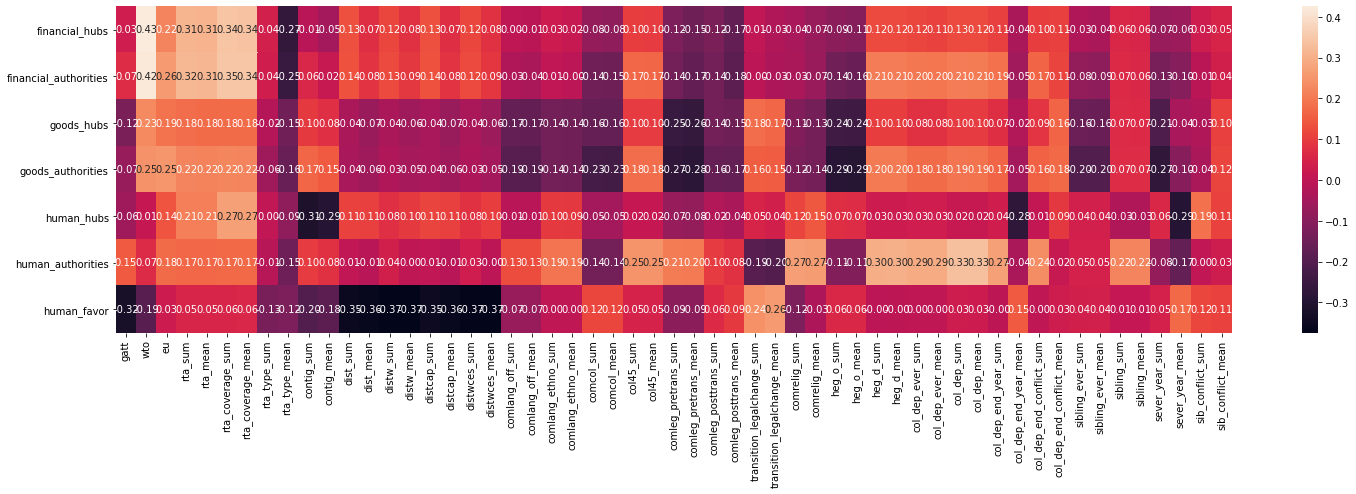

In [162]:
df_plot = df_corrs.loc[reduced_terms_list, trade_facilitation_unilateral_variables + list(df_agg_instruments.columns[2:])]
fig, ax = plt.subplots(figsize=(25,6))
sns.heatmap(df_plot, annot=True, fmt ='.2f')

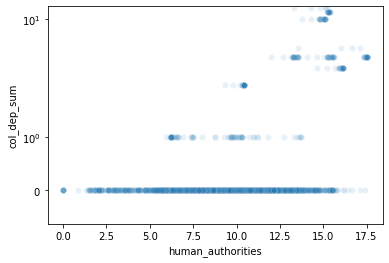

In [163]:
ax = sns.scatterplot(data=df_model_instruments, x = 'human_authorities', y = 'col_dep_sum', alpha = 0.1)
ax.set_yscale('symlog')